In [1]:
%%capture
# If you want to save 4-bit models, make sure to have `bitsandbytes>=0.41.3` installed
!pip install --no-index /kaggle/input/making-wheels-of-necessary-packages-for-hf-llms/bitsandbytes-0.42.0-py3-none-any.whl --find-links=/kaggle/input/making-wheels-of-necessary-packages-for-hf-llms
!pip install --no-index /kaggle/input/making-wheels-of-necessary-packages-for-hf-llms/accelerate-0.27.2-py3-none-any.whl --find-links=/kaggle/input/making-wheels-of-necessary-packages-for-hf-llms
!pip install --no-index /kaggle/input/making-wheels-of-necessary-packages-for-hf-llms/transformers-4.38.1-py3-none-any.whl --find-links=/kaggle/input/making-wheels-of-necessary-packages-for-hf-llms
!pip install --no-index /kaggle/input/making-wheels-of-necessary-packages-for-hf-llms/optimum-1.17.1-py3-none-any.whl --find-links=/kaggle/input/making-wheels-of-necessary-packages-for-hf-llms

In [2]:
! pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 43.7 MB/s eta 0:00:00:00:0100:01


In [3]:
! pip install pdfminer.six

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 17.5 MB/s eta 0:00:0000:0100:01


In [4]:
!pip install numba
!pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=60f957a7fd23862ab4f990bdd0f50c47e06d935bb5280274b1592728f1b55b56
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil


In [5]:
! sudo sync; echo 3 > /proc/sys/vm/drop_caches

/bin/bash: /proc/sys/vm/drop_caches: Read-only file system


In [6]:
from accelerate.utils import BnbQuantizationConfig
from accelerate import Accelerator
import transformers
import optimum
import bitsandbytes
import re


In [7]:
import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
|  1 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  4% |  1% |
|  1 |  0% |  0% |


In [8]:
import torch
from transformers import BitsAndBytesConfig
import requests
from PIL import Image

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

In [9]:
from transformers import pipeline
def load_llava():
    model_id = "llava-hf/llava-1.5-7b-hf"

    pipe = pipeline("image-to-text", model=model_id, model_kwargs={"quantization_config": quantization_config})
    return pipe

2024-04-21 07:49:59.256461: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 07:49:59.256633: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 07:49:59.521738: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
import fitz  # PyMuPDF
from IPython.display import display, HTML
import torch
from PIL import Image
import io

def extract_and_caption_images_from_pdf(pdf_path, pipe):
    # Open the provided PDF
    doc = fitz.open(pdf_path)
    
    # Store all extracted images as PIL Images
    outputs = []
    
    # Iterate through each page
    for i in range(len(doc)):
        page = doc.load_page(i)
        
        # Extract images
        for image_index, img in enumerate(page.get_images(full=True)):
            xref = img[0]
            base_image = doc.extract_image(xref)
            image_bytes = base_image["image"]
            
            # Convert bytes to a PIL Image
            image = Image.open(io.BytesIO(image_bytes))
            if image.mode != "RGB":
                image = image.convert("RGB")
            display(image)
            output = pipe(image, prompt=prompt2, generate_kwargs={"max_new_tokens": 200})
            print(output)
            outputs.append(output)

max_new_tokens = 200
prompt = "USER: <image>\nWhat are the things I should be cautious about when I visit this place?\nASSISTANT:"
prompt2 = "USER: <image>\nCan you describe this picture, considering that these content are related to Machine learning specifically Linear regression? \nASSISTANT:"
pdf_file_path = "/kaggle/input/pdffile/2-Linear_classification.pdf"  # Adjust as per your path
#extract_and_caption_images_from_pdf(pdf_file_path, pipe)

Text from Page 1:
Text from Previous Page 1:
Streaming Data Analytics
Administrative items
Emanuele Della Valle
prof @ Politecnico di Milano
emanuele.dellavalle@polimi.it
http://emanueledellavalle.org
Emanuele Della Valle - http://emanueledellavalle.org
1

Text from Current Page 2:
About me
Emanuele Della Valle
— Associate Professor, DEIB, Politecnico di 
Milano, Italy 
— 20+ years between academia and industry
— Expert in Semantic Technologies and 
Stream Processing
— Brander of Stream Reasoning
— Serial startupper :-P
Emanuele Della Valle - http://emanueledellavalle.org
2

Text from Next Page 3:
Lectures' Timetable
— Official
— Wednesday 14:15 - 16:15 in classroom 5.02
— Thursday 16:15 - 18:15 in classroom 21.S.2
— Pragmatically
— Tuesday 14:30 - 16:00 in classroom 5.02 
— Thursday 16:15 - 17:45 in classroom 21.S.2
— Important NOTES
— there is no clear cut between theory and practice
— bring your laptops we will often code
— I record ALL lectures but I do not stream them
Emanuele Del

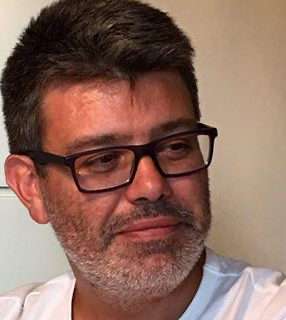

Text from Page 4:
Text from Previous Page 4:
Lectures' Recording
— I record all lectures, and I make them available the same day
— I do not stream the lectures outside the classroom (i.e., I can selectively 
admit people who are in the room)
Emanuele Della Valle - http://emanueledellavalle.org
4

Text from Current Page 5:
Objetives
The course provides the foundational concepts, 
methods, languages, and systems for ingesting, 
processing, and analyzing data that flows to 
enable real-time decisions. 
The course aims to tame the velocity 
dimensions of Big Data without forgetting the 
volume and variety dimensions.
Emanuele Della Valle - http://emanueledellavalle.org
5

Text from Next Page 6:
Prerequisites
Students are expected to know the basics of database management and SQL 
Emanuele Della Valle - http://emanueledellavalle.org
6

Displaying images from Page 5:


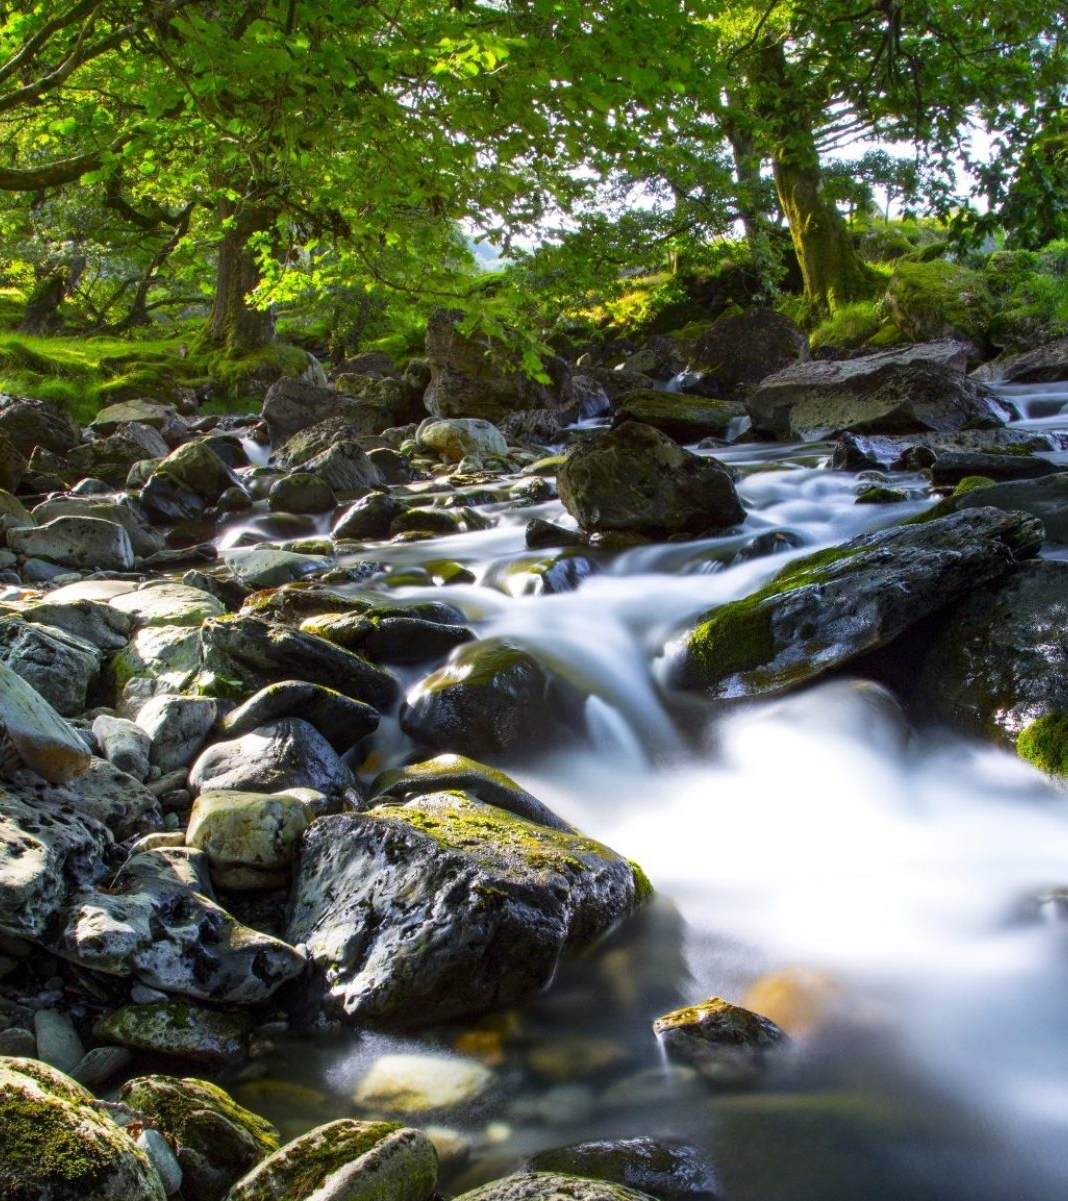

In [11]:
import fitz  # Import PyMuPDF
from pdfminer.high_level import extract_pages
from pdfminer.layout import LTTextBox, LTTextLine
from PIL import Image
import io

def find_pages_with_images(pdf_path):
    doc = fitz.open(pdf_path)
    pages_with_images = set()
    for page_number, page in enumerate(doc):
        if page.get_image_info():
            pages_with_images.add(page_number)
    doc.close()
    return pages_with_images

def extract_relevant_text_and_display_images(pdf_path, pages_with_images):
    doc = fitz.open(pdf_path)  # Open the PDF with PyMuPDF for image extraction
    pdf_text = {page_number: "" for page_number in range(len(doc))}  # Dictionary to store text of all pages

    # Extract text from all pages
    for page_number, page_layout in enumerate(extract_pages(pdf_path)):
        for element in page_layout:
            if isinstance(element, LTTextBox) or isinstance(element, LTTextLine):
                pdf_text[page_number] += element.get_text()
    text = []
    temp = ""
    images = []
    # Process each page for relevant text and images
    for page_number in sorted(pages_with_images):
        # Check and display text from the previous page, current page, and the next page
        print(f"Text from Page {page_number}:")
        if page_number > 0:  # Previous page text
            print(f"Text from Previous Page {page_number}:")
            print(pdf_text[page_number - 1])
            temp += pdf_text[page_number - 1]
        print(f"Text from Current Page {page_number + 1}:")  # Current page text
        print(pdf_text[page_number])
        temp += pdf_text[page_number]
        if page_number + 1 < len(doc):  # Next page text
            print(f"Text from Next Page {page_number + 2}:")
            print(pdf_text[page_number + 1])
            temp += pdf_text[page_number]
        text.append(temp)
        

        # Display images from the current page
        print(f"Displaying images from Page {page_number + 1}:")
        page = doc[page_number]
        for image_index, img in enumerate(page.get_images(full=True)):
            xref = img[0]
            base_image = doc.extract_image(xref)
            image_bytes = base_image["image"]
            image = Image.open(io.BytesIO(image_bytes))
            if image.mode != "RGB":
                image = image.convert("RGB")
            display(image)
            images.append(image)
            #image_stream.close()
    doc.close()
    return images, text

# Usage
pdf_file_path = "/kaggle/input/pdf-file/00.pdf"
pages_with_images = find_pages_with_images(pdf_file_path)
images, texts = extract_relevant_text_and_display_images(pdf_file_path, pages_with_images)

In [12]:
from pdfminer.layout import LAParams, LTTextBox, LTTextLine

def extract_text_from_pdf_page_by_page(pdf_path):
    # Using extract_pages to get more control over each page
    for page_layout in extract_pages(pdf_path):
        # Initialize an empty string to collect text
        page_text = ''
        # Iterate over whatever the parser finds on the page
        for element in page_layout:
            if isinstance(element, LTTextBox) or isinstance(element, LTTextLine):
                page_text += element.get_text()
        # Yield or print each page's text separately
        yield page_text

# Usage
pdf_file_path = '/kaggle/input/pdffile/2-Linear_classification.pdf'
text = ""
for page_number, page_text in enumerate(extract_text_from_pdf_page_by_page(pdf_file_path), 1):
    text += page_text

In [13]:
text

'1 Linear models for classiﬁcation\nThe goal in classiﬁcation is to take an input vector x and to assign it to one of K discrete\nclasses Ck where k = 1, ..., K. In the most common scenario, the classes are taken to be\ndisjoint, so that each input is assigned to one and only one class. The input space is thereby\ndivided into decision regions whose boundaries are called decision boundaries or decision\nsurfaces.\nIn this chapter, we consider linear models for classiﬁcation, by which we mean\nthat the decision surfaces are deﬁned by (D − 1)-dimensional hyperplanes within the D-\ndimensional input space. Data sets whose classes can be separated exactly by linear decision\nsurfaces are said to be linearly separable.\n1.1 Linear classiﬁcation\nWe will consider linear models for classiﬁcation. In the linear regression case, the model is\nlinear in parameters,\ny(x, w) =\nD−1\n(cid:88)\nj=0\nwjxj = xT w\nTo have a simpler notation in future steps we explicit w0 from w\n= w0 +\nD−1\n(cid:88)

In [14]:
text = text[:2000]

In [15]:
len(text)

2000

In [16]:
text

'1 Linear models for classiﬁcation\nThe goal in classiﬁcation is to take an input vector x and to assign it to one of K discrete\nclasses Ck where k = 1, ..., K. In the most common scenario, the classes are taken to be\ndisjoint, so that each input is assigned to one and only one class. The input space is thereby\ndivided into decision regions whose boundaries are called decision boundaries or decision\nsurfaces.\nIn this chapter, we consider linear models for classiﬁcation, by which we mean\nthat the decision surfaces are deﬁned by (D − 1)-dimensional hyperplanes within the D-\ndimensional input space. Data sets whose classes can be separated exactly by linear decision\nsurfaces are said to be linearly separable.\n1.1 Linear classiﬁcation\nWe will consider linear models for classiﬁcation. In the linear regression case, the model is\nlinear in parameters,\ny(x, w) =\nD−1\n(cid:88)\nj=0\nwjxj = xT w\nTo have a simpler notation in future steps we explicit w0 from w\n= w0 +\nD−1\n(cid:88)

In [17]:
#llava_model = load_llava()

In [18]:
#prompt2 = """USER: <image>\n Please generate a descriptive paragraph based on the provided image, focusing only on the context information provided below. Avoid incorporating details not mentioned in the"{context}". Focuse on the keywords and topic of the context. \nASSISTANT:"""
#outputs = llava_model(images[1], prompt=prompt2.format(context=texts[1]), generate_kwargs={"max_new_tokens": 1000})

In [19]:
#outputs

In [20]:
#display(images[1])

In [21]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoConfig

accelerator = Accelerator()
# Comment/Uncomment and use as per wish
MODEL_PATH_mix_7 = "/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1"

quantization_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)

In [22]:
def mix_7():
    tokenizer_mix_7 = AutoTokenizer.from_pretrained(MODEL_PATH_mix_7)
    model_mix_7 = AutoModelForCausalLM.from_pretrained(
        MODEL_PATH_mix_7,
        device_map = "auto",
        trust_remote_code = True,
        quantization_config=quantization_config,
    )
    model_mix_7 = accelerator.prepare(model_mix_7)
    return mix_7

In [23]:
def load_llama_13():    
    MODEL_PATH_llama_13 = "/kaggle/input/llama-2/pytorch/13b-chat-hf/1"
    tokenizer_llama_13 = AutoTokenizer.from_pretrained(MODEL_PATH_llama_13)
    model_llama_13 = AutoModelForCausalLM.from_pretrained(
        MODEL_PATH_llama_13,
        device_map = "auto",
        trust_remote_code = True,
        quantization_config=quantization_config,
    )
    model_llama_13 = accelerator.prepare(model_llama_13)
    return model_llama_13

In [24]:
def load_llama_70():
    MODEL_PATH_llama_70 = "/kaggle/input/llama-2/pytorch/70b-chat-hf/1"
    tokenizer_llama_70 = AutoTokenizer.from_pretrained(MODEL_PATH_llama_70)
    model_llama_70 = AutoModelForCausalLM.from_pretrained(
        MODEL_PATH_llama_70,
        device_map = "auto",
        trust_remote_code = True,
        quantization_config=quantization_config,
    )
    model_llama_70 = accelerator.prepare(model_llama_70)
    return model_llama_70

In [25]:
def load_gemma():
    model_gemma = "/kaggle/input/gemma/transformers/7b-it/2"

    pipeline_gemma = transformers.pipeline(
        "text-generation",
        model=model_gemma,
        torch_dtype=torch.float16,
        device_map="auto",
    )
    return pipeline_gemma

In [26]:
def load_llama_3():
    model_llama_3 = "/kaggle/input/llama-3/transformers/8b-chat-hf/1"

    pipeline_llama = transformers.pipeline(
        "text-generation",
        model=model_llama_3,
        torch_dtype=torch.float16,
        device_map="auto",
    )
    return pipeline_llama

In [27]:
def mix_48():
    MODEL_PATH = "/kaggle/input/mixtral/pytorch/8x7b-instruct-v0.1-hf/1"
    quantization_config = BitsAndBytesConfig(
        load_in_4bit = True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=True,
    )

    tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)


    model = AutoModelForCausalLM.from_pretrained(
        MODEL_PATH,
        device_map = "auto",
        trust_remote_code = True,
        quantization_config=quantization_config,
    )

    # model = model.to_bettertransformer()
    model = accelerator.prepare(model)
    return model, tokenizer

In [28]:
def query_model(prompt, pipeline, temperature=0.7,max_length=512):
    sequences = pipeline(
        prompt,
        do_sample=True,
        top_k=10,
        temperature=temperature,
        num_return_sequences=1,
        eos_token_id=pipeline.tokenizer.eos_token_id,
        max_length=max_length,
    )
    answer = f"{sequences[0]['generated_text'][len(prompt):]}\n"

    return prompt + "****" + answer

In [29]:
def prompting(model, text, tokenizer):
    #torch.cuda.empty_cache()
    #gc.collect()
    device = accelerator.device
    messages = [
            {
                "role": "user",
                "content": text
            }
    ]
    encoded_input = tokenizer.apply_chat_template(messages, return_tensors="pt", add_generation_prompt=True).to(device)

    with torch.no_grad():
        encoded_output = model.generate(encoded_input, max_new_tokens=1000, do_sample=True, pad_token_id=tokenizer.eos_token_id)

    decoded_output = tokenizer.batch_decode(encoded_output, skip_special_tokens=True)[0]
    decoded_output = result = re.sub(r"[\s\S]*\[\/INST\]", '', decoded_output, 1)
    return decoded_output

In [30]:
model, tokenizer = mix_48()

Loading checkpoint shards:   0%|          | 0/19 [00:00<?, ?it/s]

In [33]:
def multi_agent_working(text, model, tokenizer):
    prompt = """
    As someone trying to understand the provided study material text, I need comprehensive and detailed lecture notes to understand the material thoroughly. 
    First, determine my level and accordingly, ensure the notes cover all key topics, concepts, examples, and any supplementary material presented in the document. 
    Include explanations, diagrams, and relevant details to help me grasp the content easily according to my level. 
    Additionally, provide a summary of all the notes in bullet points format to be studied in the very last minute before its exam to aid in quick revision.  
    Additionally, tell me the necessary topics to study them one after another to learn all the key topics present in the text.
    Also, try to avoid unnecessary explanations.
    study material text: {text}
    """
    #response = query_model(prompt.format(text=text), pipeline_gemma, max_length=1000)
    output1 = prompting(model, prompt.format(text=text), tokenizer)
    print("Level one output: ")
    print(output1)
    prompt1 = """
    You are an AI assistant designed to help me with my education. I have a text and some notes explaining them. By comparing them, give me the refined and improve version of the notes, ensuring ALL and ALL these points:
    Ensure the notes cover all key topics, concepts, examples, and any supplementary material presented in the document.
    Ensure explanations, diagrams, and relevant details help me grasp the content easily according to my level.
    Ensure there are bullet points, and they explain everything for a last-minute study. If not, create them for a last-minute study.
    Ensure there are no unnecessary explanations, that is those making understanding the material more complex.
    The text is {text} and the notes are {output}.
    """
    print("**********************************************************************")
    output2 = prompting(model, prompt1.format(text=text, output=output1), tokenizer)
    print("Level two output:")
    print(output2)
    
    prompt2 = """
    You are an AI assistant designed to assist with educational tasks. You have a document containing text along with accompanying notes intended to clarify and summarize the content. Your task is to refine and improve these notes comprehensively, ensuring they meet the following criteria:
    Coverage: The notes must encompass all essential topics, concepts, examples, and supplementary materials presented in the document.
    Clarity: Explanations, diagrams, and relevant details should facilitate easy understanding tailored to your level of comprehension.
    Structure: The notes should be structured with bullet points, offering a concise overview suitable for last-minute study. If bullet points are lacking, they should be incorporated to enhance accessibility.
    Simplicity: Avoid unnecessary complexities in explanations, ensuring that the material is presented in a straightforward manner conducive to understanding.
    The text is {text} and the notes are {output}.
    """
    print("**********************************************************************")
    output3 = prompting(model, prompt2.format(text=text, output=output2), tokenizer)
    print("Level Three output:")
    print(output3)
    
    
    prompt3 = """
    As your AI assistant, I'm tasked with refining (imporving) and integrating lecture notes for you. Here's what I need from the final version of these notes:

    Comprehensive Coverage: Ensure that the notes encapsulate all key topics, main concepts, and examples mentioned across the texts. Include any supplementary material that enhances understanding of these points.
    Tailored Explanations: Provide detailed explanations and illustrate with diagrams where necessary. The explanations should be tailored to your educational level, facilitating easy comprehension without oversimplifying or omitting crucial details.
    Last-Minute Revision: Include a section of bullet points for each topic, designed for last-minute revision. These bullet points should succinctly summarize the essential information, ensuring they are ready for quick review.
    Clarity and Conciseness: Avoid including any redundant explanations or overly complex descriptions that could hinder understanding rather than aiding it.
    To accomplish this, I will merge and refine the information from the following texts:

    Text 1: {output1}
    Text 2: {output2}
    Text 3: {output3}
    Ensure that the final notes are coherent, concise, and structured effectively to aid in both detailed study and rapid revision.
    """
    print("**********************************************************************")
    output = prompting(model, prompt3.format(output1=output1, output2=output2, output3=output3), tokenizer)
    print("Level Four output:")
    print(output)
    
    roadmap_prompt = """
    You are an AI assistant tasked with developing a structured educational roadmap for tutors based on key topics and essential concepts extracted from educational sources. 
    Your goal is to outline a clear, logical sequence of learning steps, including necessary pre-knowledge and subsequent topics, to facilitate effective teaching and understanding. 
    When crafting the roadmap, adhere to the following guidelines:
    Begin with a brief review of the extracted topics and important concepts from the educational source provided in the text. This will set the foundation for the roadmap. 
    The extracted topics and text is {text}.
    Determine and list the foundational knowledge or pre-requisite topics that tutors must understand or teach first to ensure a smooth progression into more complex topics. 
    These should be listed as the initial steps in the roadmap.
    Arrange the main topics extracted from the text in a logical educational sequence. 
    Consider the complexity and interdependence of topics to build a progressive learning path.
    Within each main topic, integrate critical concepts that need detailed exploration. 
    Specify any particular insights or deeper understanding required for each topic, guiding tutors on focus areas for thorough explanation.
    Outline a six-step roadmap, starting from the pre-requisite knowledge to the advanced topics. 
    Ensure each step is clearly defined and includes specific learning objectives that lead to the next step. 
    This should maintain a clear, concise, and actionable format.
    Your roadmap should serve as a practical guide for tutors, organizing the learning process into manageable and logical steps that enhance teaching efficiency and learning outcomes. 
    This structured approach should facilitate a comprehensive understanding of the subject matter, ensuring all necessary topics are covered in the correct order.
    """
    print("**********************************************************************")
    roadmap = prompting(model, roadmap_prompt.format(text=output), tokenizer)
    print("Road Map of Learning:")
    print(roadmap)
    
    exam_prompt = """
    You are an AI assistant tasked with designing a practice quiz based on the refined and integrated lecture notes produced by me. 
    Here are the guidelines for creating an effective quiz:
    Develop a set of one questions that utilize a mix of formats, including multiple-choice, true/false, and fill-in-the-blank. 
    This variety will help evaluate different levels of understanding and retention.
    Each question should target a key concept or topic covered in the lecture notes. 
    Ensure the questions are designed to test both factual recall and the application of these concepts in new contexts.
    Frame the questions in clear and concise language. Avoid ambiguous phrasing and ensure that each question is straightforward, focusing solely on the material from the notes.
    If applicable, include questions that refer to diagrams from the notes. 
    These questions should require the user to interpret or explain these diagrams, testing their understanding of visual information.
    Include correct answers for each question. For multiple choice questions, also list incorrect options that are plausible but can be logically deduced as incorrect based on the notes.
    Here are the notes from the third-layer model to be used for this quiz:
    {text}
    Create the quiz ensuring it serves as both a learning tool and an assessment method, helping users to reinforce their understanding and prepare effectively for further evaluations.
    """
    print("**********************************************************************")
    exam = prompting(model, exam_prompt.format(text=output), tokenizer)
    print("QIZZ!!!!!:")
    print(exam)
    
    return output, roadmap, exam

In [34]:
output, roadmap, exam = multi_agent_working(text, model, tokenizer)

Level one output: 
 Based on your request, I will provide comprehensive lecture notes for the given study material text on linear models for classification, assuming you have a basic understanding of linear regression. I will include explanations, diagrams, and relevant details, while avoiding unnecessary information.

**Lecture Notes:**

1. Classification
   - The goal: Assign an input vector x to one of K discrete classes Ck, where k = 1, ..., K.
   - Decision regions: Areas in the input space where all inputs belonging to a certain class are present.
   - Decision boundaries or decision surfaces: Boundaries separating decision regions.


**********************************************************************
Level two output:
 **Lecture Notes: Linear Models for Classification**

1. **Classification**
   - Goal: Assign an input vector x to one of K discrete classes Ck, where k = 1, ..., K.
   - Decision regions: Areas in the input space where all inputs belonging to a certain class ar